**# RCV1 Dataset**

**Problem Statement **: Developing a Multi-Label Classification Model Using the RCV1 Dataset for Accurate News Articles Classification

In [2]:
# Import required for project
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, hamming_loss,precision_score, recall_score
from sklearn.preprocessing import scale, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_rcv1
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
import warnings
import pandas as pd
import sklearn.metrics

**Note :** This file is second iteration of trying to run the models with slightly higher data samples of 10,000 records. Anything beyong this is crashing

In [3]:
# fetching the data for rcv1_data set
rcv1 = fetch_rcv1()

In [4]:
# Split the data into training and testing sets.

# Extract features (X) and target labels (y) from the dataset
X = rcv1.data
y = rcv1.target
# Specify the number of samples for training and testing
num_train_samples = 7000
num_test_samples = 3000

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=num_train_samples, test_size=num_test_samples, shuffle=False
)

**Conduct Exploratory Data Analysis**
Began with converting the dataset from sparse matrix to dense array

In [5]:
# Convert y_train and X_train to dense arrays
y_train = y_train.toarray()
X_train = X_train.toarray()
# Convert y_test and X_test to dense arrays
X_test = X_test.toarray()
y_test = y_test.toarray()

Identified columns that have all zero values for feature and dropped them, similarly identified columns which have all zeros for target and dropped them as well

In [6]:
# Define feature names for both training and testing sets
feature_names = [f"feature_{i}" for i in range(X_train.shape[1])]
feature_df_train = pd.DataFrame(X_train, columns=feature_names)

feature_names = [f"feature_{i}" for i in range(X_test.shape[1])]
feature_df_test = pd.DataFrame(X_test, columns=feature_names)

# Create DataFrames for training targets and testing targets
target_names = rcv1.target_names
target_df_train = pd.DataFrame(y_train, columns=target_names)
target_df_test = pd.DataFrame(y_test, columns=target_names)

In [7]:
# Identify columns with all zero values in the training features
zero_columns = feature_df_train.columns[feature_df_train.eq(0).all()]

# Drop columns with all zero values from training and testing feature DataFrames
feature_df_train.drop(columns=zero_columns, inplace=True)
feature_df_test.drop(columns=zero_columns, inplace=True)


In [8]:
# Identify columns with all zero values in the training targets
zero_columns = target_df_train.columns[target_df_train.eq(0).all()]

# Drop columns with all zero values from training and testing target DataFrames
target_df_train.drop(columns=zero_columns, inplace=True)
target_df_test.drop(columns=zero_columns, inplace=True)

**Feature Engineering and Visualization**

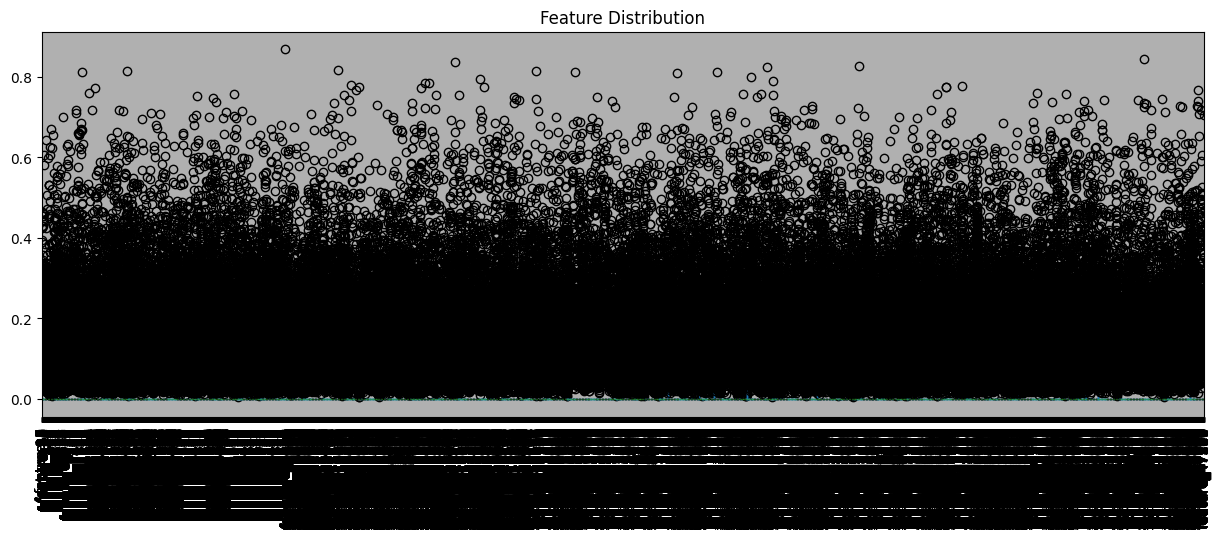

In [9]:
# Feature distribution
plt.figure(figsize=(15, 5))
feature_df_train.boxplot(rot=90)
plt.title("Feature Distribution")
plt.show()

Class Distribution diagram shows imbalanced data distribution, hence Min-Max Scaling is performed.

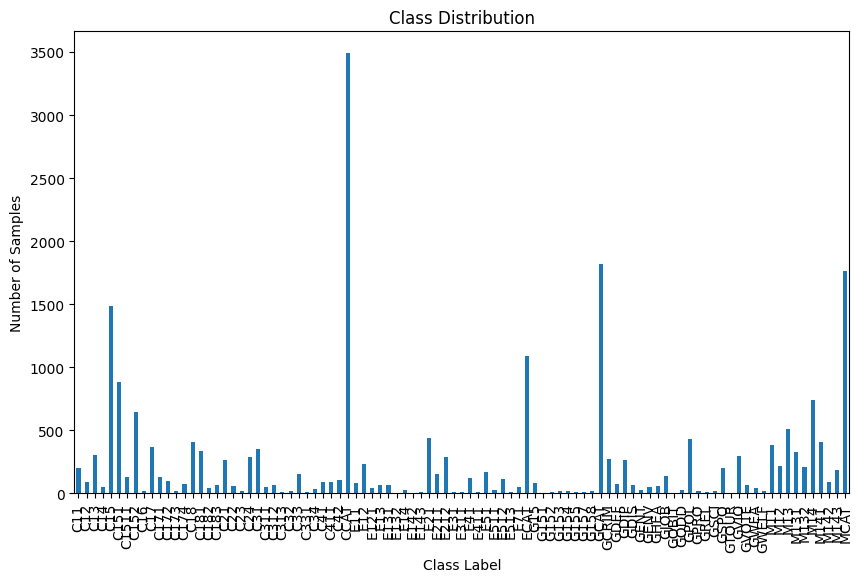

In [10]:
# Class distribution
plt.figure(figsize=(10, 6))
target_df_train.sum().plot(kind='bar')
plt.title("Class Distribution")
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.show()

In [10]:
# Scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(feature_df_train)
X_test_scaled = scaler.transform(feature_df_test)

Model Building and Regularization

**Note :** As the problem statement involves multilabel classification, I have incorporated additional performance metrics, including precision, recall, and accuracy. An additional component, hamming loss, has been utilized for comprehensive evaluation.
Hamming loss: Measures the fraction of labels that are incorrectly predicted. It is the ratio of the incorrect predictions to the total number of labels. Hamming Loss = Number of Incorrect Predictions/Total Number of Labels

Note: As the exploration of models with just scaling and withut PCA is already done with previous samples of 1000 records and it took more than 90 minutes for each model to run. I have directly used models with PCA and gradient descent.


**Dimensionality Reduction, Performance Measurement, and Model Evaluation**

In [11]:
# Performing PCA
pca = PCA(n_components=0.95)  # Keeping 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [12]:
# 1. linear SVM with PCA and gradient descent 
# Initialize the SGDClassifier
sgd_classifier = SGDClassifier(loss='hinge',  # For linear SVM
                               alpha=0.0001,  # Regularization strength
                               max_iter=1000,  # Number of iterations
                               tol=1e-3,  # Tolerance to declare convergence
                               random_state=42)

# Wrap the classifier with MultiOutputClassifier for multi-label classification
svm_model = MultiOutputClassifier(sgd_classifier)


# Train the model on the training set
svm_model.fit(X_train_pca, target_df_train)

# Make predictions on the testing set
y_pred = svm_model.predict(X_test_pca)

# Evaluate the model
# Evaluate the performance
hamming_loss_value = hamming_loss(target_df_test, y_pred)
precision = precision_score(target_df_test, y_pred, average='micro')
recall = recall_score(target_df_test, y_pred, average='micro')
accuracy = accuracy_score(target_df_test, y_pred)

# Print the evaluation metrics  
print("Metrics Performance for SVM with PCA and gradient descent  :")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Hamming Loss: {hamming_loss_value * 100:.2f}%")
print(f"Weighted Precision: {precision * 100:.2f}%")
print(f"Weighted Recall: {recall * 100:.2f}%")


Metrics Performance for SVM with PCA and gradient descent  :
Accuracy: 51.93%
Hamming Loss: 1.13%
Weighted Precision: 89.26%
Weighted Recall: 74.67%


**Observation:** To perform gradient descent, continuous parameters are required, and the loss function must be differentiable with respect to these parameters. Random forests, however, have discrete hyperparameters (such as tree depth, number of trees, number of features, etc.). Consequently, gradient descent is not applicable in this context.

In [14]:
# 2.Random forest with PCA
# Create a RandomForestClassifier instance
rf_classifier_pca = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the classifier on the training data with PCA-transformed features
rf_classifier_pca.fit(X_train_pca, target_df_train)

# Make predictions on the test set with PCA-transformed features
y_pred = rf_classifier_pca.predict(X_test_pca)

# Evaluate the performance
hamming_loss_value = hamming_loss(target_df_test, y_pred)
precision = precision_score(target_df_test, y_pred, average='micro')
recall = recall_score(target_df_test, y_pred, average='micro')
accuracy = accuracy_score(target_df_test, y_pred)

# Print the evaluation metrics  
print("Metrics Performance for Random forest with PCA :")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Hamming Loss: {hamming_loss_value * 100:.2f}%")
print(f"Weighted Precision: {precision * 100:.2f}%")
print(f"Weighted Recall: {recall * 100:.2f}%")

Metrics Performance for Random forest with PCA :
Accuracy: 11.03%
Hamming Loss: 2.57%
Weighted Precision: 89.29%
Weighted Recall: 25.38%


In [23]:
# 3. Linear Regression with PCA and gradient descent
# Create an SGDClassifier for Logistic Regression
sgd_classifier = SGDClassifier(loss='log_loss', alpha=0.01, max_iter=1000, random_state=42)

# Wrap the classifier with MultiOutputClassifier for multi-label classification
logistic_regression_model = MultiOutputClassifier(sgd_classifier)

# Train the model on the training set
logistic_regression_model.fit(X_train_pca, target_df_train)

# Make predictions on the testing set
y_pred = logistic_regression_model.predict(X_test_pca)

# Evaluate the performance
hamming_loss_value = hamming_loss(target_df_test, y_pred)
precision = precision_score(target_df_test, y_pred, average='micro')
recall = recall_score(target_df_test, y_pred, average='micro')
accuracy = accuracy_score(target_df_test, y_pred)

# Print the evaluation metrics  
print("Metrics Performance for Logistic Regression with PCA and gradient descent :")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Hamming Loss: {hamming_loss_value * 100:.2f}%")
print(f"Weighted Precision: {precision * 100:.2f}%")
print(f"Weighted Recall: {recall * 100:.2f}%")


Metrics Performance for Logistic Regression with PCA and gradient descent :
Accuracy: 5.63%
Hamming Loss: 2.35%
Weighted Precision: 95.42%
Weighted Recall: 30.26%


**Observation :**Multinomial Naive Bayes is a probabilistic classification algorithm, and it typically doesn't use gradient descent for optimization. Instead, it estimates probabilities directly from the training data. The parameters in Multinomial Naive Bayes are probabilities associated with each term (feature) in each class.

In [22]:
# 4.Naive Bayse with hyper parameter tunning
# To ignore all warnings
warnings.filterwarnings("ignore")

# Create a Multinomial Naive Bayes classifier
nb_classifier = MultinomialNB()

# Define the parameter grid for the grid search
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0]}

# Create a GridSearchCV object
grid_search = GridSearchCV(nb_classifier, param_grid, scoring='accuracy')

# Create a MultiOutputClassifier with the grid search
nb_model = MultiOutputClassifier(grid_search)

# Fit the model on the training data
nb_model.fit(X_train_scaled, target_df_train)

# Access the best hyperparameters from the GridSearchCV object
best_params = nb_model.estimators_[0].best_params_
print("Best Hyperparameters:", best_params)

# Predict on the test set using the best model
y_pred = nb_model.predict(X_test_scaled)

# Evaluate the performance
hamming_loss_value = hamming_loss(target_df_test, y_pred)
precision = precision_score(target_df_test, y_pred, average='micro')
recall = recall_score(target_df_test, y_pred, average='micro')
accuracy = accuracy_score(target_df_test, y_pred)

# Print the evaluation metrics  
print("Metrics Performance for Naive Bayse with hyper parameter tunning :")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Hamming Loss: {hamming_loss_value * 100:.2f}%")
print(f"Weighted Precision: {precision * 100:.2f}%")
print(f"Weighted Recall: {recall * 100:.2f}%")


Best Hyperparameters: {'alpha': 2.0}
Metrics Performance for Naive Bayse with hyper parameter tunning :
Accuracy: 25.27%
Hamming Loss: 2.53%
Weighted Precision: 64.22%
Weighted Recall: 52.91%


Performance Analysis 1.Linear SVM: The performance of Linear SVM after PCA and gradient descent, achieving an accuracy of 51.93% and a hamming loss of 1.13%.
2.Random Forest: In Random Forest with PCA resulted performance, with an accuracy of 11.03% and a hamming loss of 2.57%.
3.Logistic Regression: Logistic Regression after PCA and gradient descent, with an accuracy of 5.63% and a hamming loss of 2.35%.
4.Naive Bayes: Naive Bayes demonstrated improved performance, achieving an accuracy of 25.27% and a hamming loss of 2.53%.
In comparison to all the above models, Linear SVM after PCA and gradient descent delivered the best performance with an accuracy of 51.93% and a minimum loss of 1.13%.

**Conclusion :**
1.The model's performance may vary based on the size of the sample set of the rcv1 dataset. Currently, the model is exposed to only a partial part of all the possible variations.
2.According to the analysis, Linear SVM is the best model for performing multilabel classification as of now.